<a href="https://colab.research.google.com/github/garnetraven/CLC-8/blob/main/notebooks/GuardFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GuardFlow

## Import Modules

In [ ]:
pip install tld

In [ ]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress
import ipywidgets as widgets
import base64
import logging
from io import BytesIO
from tld import get_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl
from urllib.parse import urlparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from IPython.display import display, clear_output, HTML

## Preprocess Data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Data/url_benign_malicious.csv")
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
data.isnull().sum()

,0
url,0
type,0


In [ ]:
type_count = data.type.value_counts()
type_count

,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


Text(0, 0.5, 'Count')

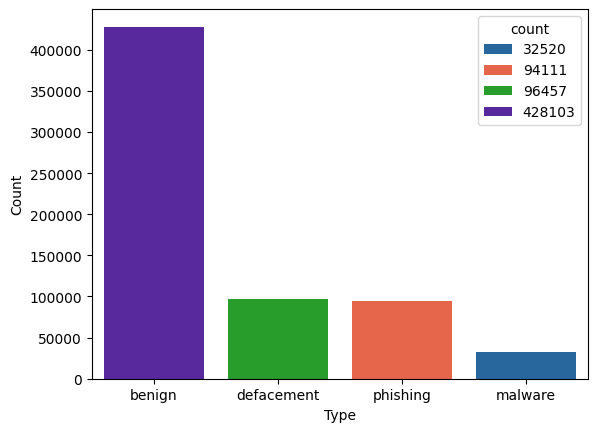

In [ ]:
sns.barplot(x = type_count.index, y = type_count, hue = type_count, palette = ["#1469b1", "#ff5531", "#14b119", "#5414b1"])
plt.xlabel("Type")
plt.ylabel("Count")

In [ ]:
data["url"] = data["url"].replace({"www.": ""}, regex=True)
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
# Map url type to category
category_mapping = {"category": {"benign": 0, "defacement": 1, "phishing": 2, "malware": 3}}
data["category"] = data["type"]
data = data.replace(category_mapping)
data.head()

<ipython-input-54-e26fb908f16c>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(category_mapping)


,url,type,category
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


### Feature Extraction

In [ ]:
data["url_len"] = data["url"].str.len()

In [ ]:

def process_tld(url):
    try:
        tld_result = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        network_location = tld_result.parsed_url.netloc
    except :
        network_location = None
    return network_location


In [ ]:
data["domain name"] = data["url"].map(process_tld)


In [ ]:
data.head()

,url,type,category,url_len,domain name
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [ ]:
# Regex characters
character_features = ["@", "?", "-", "=", ".", "%", "#", "+", "$", "!", "*", ",", "//"]
for character in character_features:
  escaped_character = re.escape(character) # process metacharacters ("+", "?", ".", "*")
  data[character] = data["url"].str.count(escaped_character)


In [ ]:
data.head()

,url,type,category,url_len,domain name,@,?,-,=,.,%,#,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [ ]:
def atypical_url(url):
  hostname = urlparse(url).hostname
  hostname = str(hostname)
  match = re.search(hostname, url)
  if match:
    return 1
  else:
    return 0


In [ ]:
data["atypical_url"] = data["url"].map(atypical_url)


<Axes: xlabel='atypical_url', ylabel='count'>

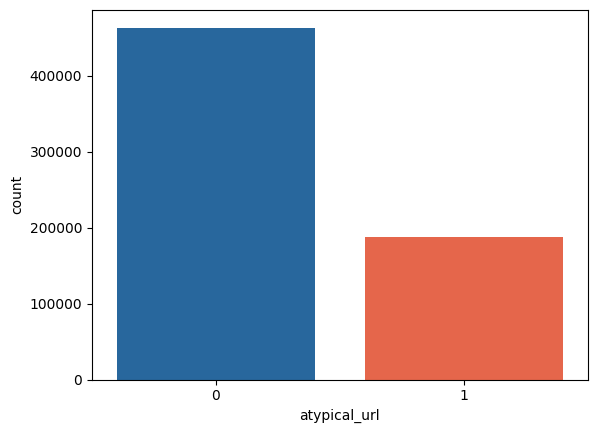

In [ ]:
sns.countplot(x = "atypical_url", hue = "atypical_url", data = data, palette = ["#1469b1", "#ff5531"], legend = False)

In [ ]:
def httpSecure(url):
  http = urlparse(url).scheme
  match = str(http)
  if match == "https":
    return 1
  else:
    return 0


In [ ]:
data["https"] = data["url"].map(httpSecure)


Text(0, 0.5, 'Count')

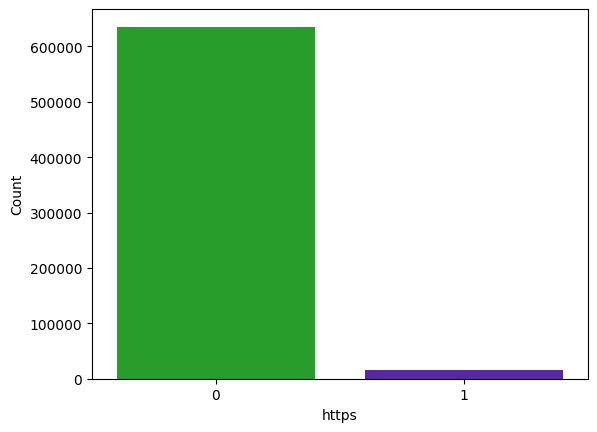

In [ ]:
sns.countplot(x = "https", hue = "https", data = data, palette = ["#14b119", "#5414b1"], legend = False)
plt.xlabel("https")
plt.ylabel("Count")

In [ ]:
# Count digits in url
def digit_count(url):
    digits = 0
    for char in url:
        if char.isnumeric():
            digits = digits + 1
    return digits


In [ ]:
data["digits"]= data["url"].map(digit_count)


In [ ]:
def letter_count(url):
    letters = 0
    for char in url:
        if char.isalpha():
            letters = letters + 1
    return letters


In [ ]:
data["letters"]= data["url"].map(digit_count)


In [ ]:
def shortening_service(url):
    shortening_services = {
      "bit.ly", "goo.gl", "shorte.st", "go2l.ink", "x.co", "ow.ly", "t.co", "tinyurl", "tr.im", "is.gd", "cli.gs",
      "yfrog.com", "migre.me", "ff.im", "tiny.cc", "url4.eu", "twit.ac", "su.pr", "twurl.nl", "snipurl.com",
      "short.to", "BudURL.com", "ping.fm"
    }

    return int(any(service in url for service in shortening_services))


In [ ]:
data["shortening_service"] = data["url"].map(shortening_service)


<Axes: xlabel='shortening_service', ylabel='count'>

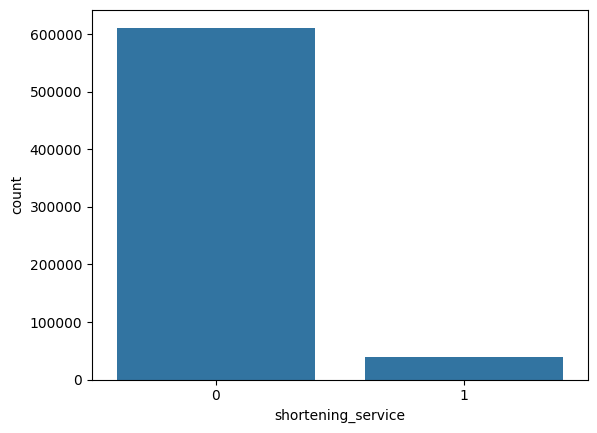

In [ ]:
sns.countplot(x = "shortening_service", data = data)

In [ ]:
def has_ip_address(url):
  try:
    parsed_url = urlparse(url)
    host = parsed_url.netloc.split(":")[0] # Remove port if exists
    ipaddress.ip_address(host)
    return 1
  except ValueError:
    return 0


In [ ]:
data["has_ip_address"] = data["url"].map(has_ip_address)


In [ ]:
data["has_ip_address"].value_counts()

,count
has_ip_address,
0,639102
1,12089


In [ ]:
data.head()

,url,type,category,url_len,domain name,@,?,-,=,.,...,!,*,",",//,atypical_url,https,digits,letters,shortening_service,has_ip_address
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,1,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,1,1,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,1,1,0,7,7,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,1,1,0,22,22,0,0


<Axes: >

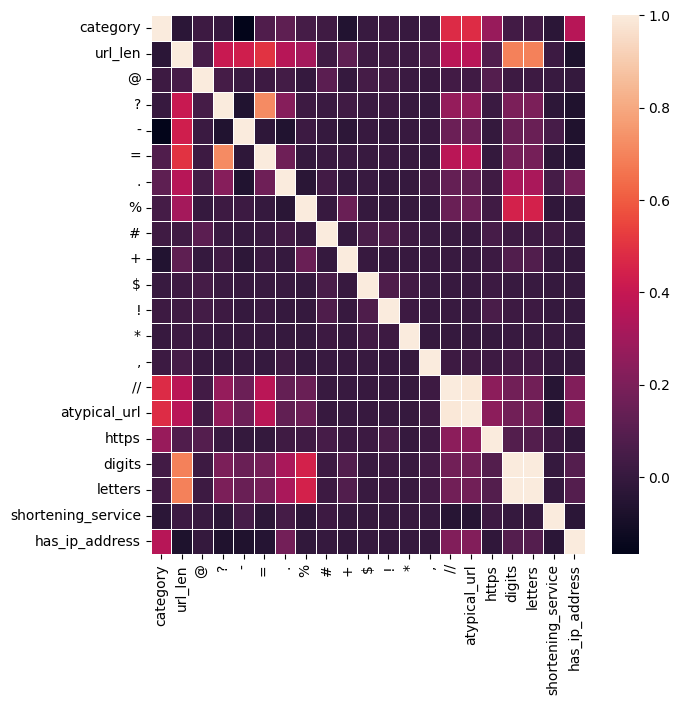

In [ ]:
plt.figure(figsize=(7,7))
sns.heatmap(data.corr(numeric_only=True), linewidths=0.5)

## Split Data

In [ ]:
X = data.drop(["url", "type", "category", "domain name"], axis=1)
Y = data["category"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


## Model Training

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, Y_train)


RandomForestClassifier(random_state=42)

## Evaluation

Test Accuracy :  87.59%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     85778
           1       0.91      0.96      0.94     19104
           2       0.78      0.29      0.43     18836
           3       0.94      0.90      0.92      6521

    accuracy                           0.88    130239
   macro avg       0.88      0.78      0.80    130239
weighted avg       0.87      0.88      0.85    130239

             Confusion_matrix 


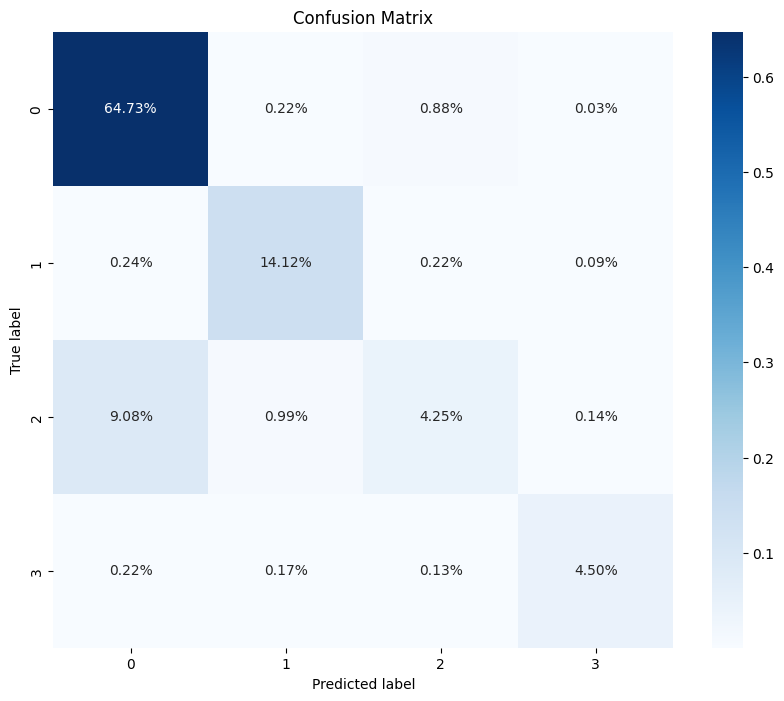

In [ ]:
pred = rf_classifier.predict(X_test)

acc = accuracy_score(Y_test, pred)
print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))

print('\033[01m              Classification_report \033[0m')
print(classification_report(Y_test, pred))

print('\033[01m             Confusion_matrix \033[0m')
cf_matrix = confusion_matrix(Y_test, pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='0.2%', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
def analyze_url(url):
    url = url.replace("www.", "")
    features = {
        "url_len": len(url),
        "atypical_url": atypical_url(url),
        "https": httpSecure(url),
        "digits": digit_count(url),
        "letters": letter_count(url),
        "shortening_service": shortening_service(url),
        "has_ip_address": has_ip_address(url)
    }

    character_features = ["@", "?", "-", "=", ".", "%", "#", "+", "$", "!", "*", ",", "//"]
    for character in character_features:
        escaped_character = re.escape(character)
        features[character] = url.count(escaped_character)

    expected_features = ['url_len', '@', '?', '-', '=', '.', '%', '#', '+', '$', '!', '*',
                         ',', '//', 'atypical_url', 'https', 'digits', 'letters',
                         'shortening_service', 'has_ip_address']

    ordered_features = {feature: features.get(feature, 0) for feature in expected_features}
    return pd.DataFrame([ordered_features])

# (benign, defacement, phishing, malware)
def predict_url(url):
    features = analyze_url(url)
    prediction = rf_classifier.predict(features)[0]
    probabilities = rf_classifier.predict_proba(features)[0]

    category_mapping = {0: "benign", 1: "defacement", 2: "phishing", 3: "malware"}
    result = category_mapping[prediction]

    return result, probabilities

In [ ]:
url_input = widgets.Text(description="Enter URL:", style={'description_width': 'initial'})
analyze_button = widgets.Button(description="Analyze", button_style='info')
output = widgets.Output()

def create_feature_heatmap(features):
    feature_list = ['@', '?', '-', '=', '.', '%', '#', '+', '$', '!', '*', ',', '//',
                    'atypical_url', 'https', 'shortening_service', 'has_ip_address']

    heatmap_data = features[feature_list].T.rename(columns={0: 'Value'})

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', cbar=False, fmt='g')
    plt.title('URL Feature Heatmap')
    plt.ylabel('Features')
    plt.xlabel('Presence (0 = Absent, 1+ = Present)')

    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    plt.close()

    img_str = base64.b64encode(buf.getvalue()).decode()

    return f'<img src="data:image/png;base64,{img_str}" style="width:100%;max-width:800px;">'


# Logging
logging.basicConfig(filename='url_analyzer.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Query dropdown menu
query_dropdown = widgets.Dropdown(
    options=['Show first 5 rows', 'Show column names', 'Show data types'],
    description='Dataset Query:',
    disabled=False,
)

def on_query_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        query = change['new']
        with output:
            clear_output()
            if query == 'Show first 5 rows':
                display(data.head())
            elif query == 'Show column names':
                display(data.columns)
            elif query == 'Show data types':
                display(data.dtypes)
        logging.info(f"Dataset query executed: {query}")

query_dropdown.observe(on_query_change, names='value')

def on_button_click(b):
    with output:
        clear_output()
        url = url_input.value
        if url:
            logging.info(f"Analyzing URL: {url}")
            features = analyze_url(url)
            result, probabilities = predict_url(url)

            is_safe = result == "benign"
            if is_safe:
              safety_color = "#4CAF50"
              safety_text = "SAFE"
            else:
              safety_color = "#F44336"
              safety_text = "MALICIOUS"

            html_output = f"""
            <h2 style="color: {safety_color}; text-align: center; font-size: 24px;">
                This website is <span style="font-weight: bold;">{safety_text}</span>
            </h2>
            <p style="text-align: center; font-size: 18px;">
                The URL is predicted to be: <strong>{result}</strong>
            </p>
            <table style="width: 60%; margin: 20px auto; border-collapse: collapse; font-size: 14px;">
                <tr style="background-color: #e0e0e0;">
                    <th style="color: #000; padding: 8px; text-align: left; border: 1px solid #bbb;">Category</th>
                    <th style="color: #000; padding: 8px; text-align: left; border: 1px solid #bbb;">Probability</th>
                </tr>
            """

            categories = ["Benign", "Defacement", "Phishing", "Malware"]
            for i, category in enumerate(categories):
                prob = probabilities[i]
                bg_color = f"rgba({int(255 * (1-prob))}, {int(255 * prob)}, 0, 0.2)"
                html_output += f"""
                <tr style="background-color: {bg_color};">
                    <td style="padding: 6px; border: 1px solid #bbb;">{category}</td>
                    <td style="padding: 6px; border: 1px solid #bbb;">{prob:.2%}</td>
                </tr>
                """

            html_output += "</table>"

            heatmap_html = create_feature_heatmap(features)
            html_output += f"""
            <h3 style="text-align: center; margin-top: 30px;">URL Feature Heatmap</h3>
            <div style="display: flex; justify-content: center;">
                {heatmap_html}
            </div>
            """

            display(HTML(html_output))
            logging.info(f"Analysis complete for URL: {url}. Result: {result}")
        else:
            print("Please enter a URL")
            logging.warning("Empty URL submitted")

analyze_button.on_click(on_button_click)

container = widgets.VBox([
    widgets.HBox([url_input, analyze_button]),
    query_dropdown,
    output
])

display(container)

#
# INSTRUCTIONS
#
# Test URLs:
# corporationwiki.com/Ohio/Columbus/frank-s-benson-P3333917.aspx
# http://www.marketingbyinternet.com/mo/e56508df639f6ce7d55c81ee3fcd5ba8/
# http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E5%8D%81%E5%9B%9B%E5%AD%9D%E5%B8%83%E8%B4%B4%E7%94%BB/
#
# You can also use URLs from the dataset provided to test
# Note: the model has a very hard time distinguishing between defacement and phishing URLs (FYI. in case you encounter this issue)
#
#
# 1. Enter the URL you want to analyze in the text box labeled "Enter URL".
# 2. Click the blue "Analyze" button to start the analysis.
# 3. Wait for results to appear. They results will show:
#         - Text indicating whether the website is SAFE or MALICIOUS
#         - The predicted category of the URL (benign, defacement, phishing, or malware)
#         - A table showing the probability of each category
#         - A heatmap displaying the features of the URL
# 4. To analyze another URL, enter the new URL intpo the input field and click "Analyze" again.
#
# This tool prototypes the machine learning Chrome extension that will analyze websites visited and help users determine the validity of them.


